**Lab Assignment-1: Enhanced Dynamic Robot Movement Simulation**

UCS Solution Path: [(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
UCS Battery Recharge Count: 3
A* Solution Path: [(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
A* Battery Recharge Count: 3
Both UCS and A* are same effective.


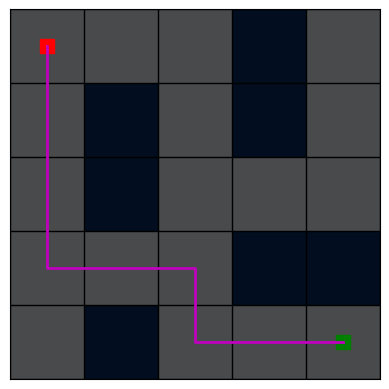

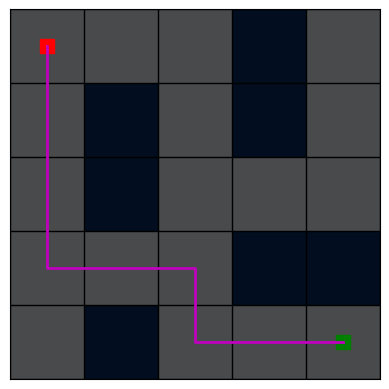

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

# Node Class represents a state in the search tree.
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    # Comparison operator for the priority queue.
    def __lt__(self, other):
        return self.path_cost < other.path_cost



#Calculate the Manhattan distance between two points a and b.
def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2) #Returns: - The Manhattan distance between points a and b.



# Environment Class represents the grid and handles state transitions.
class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.initial = start
        self.goal = goal
        self.battery_level = 100
        self.recharge_count = 0

    # Returns the possible actions from a given state.
    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        # Eliminates impossible actions based on grid boundaries and obstacles.
        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    # Returns the state resulting from taking a given action at a given state.
    def result(self, state, action):
        x, y = state

        if action == 'UP':
            new_state = (x - 1, y)
        elif action == 'DOWN':
            new_state = (x + 1, y)
        elif action == 'LEFT':
            new_state = (x, y - 1)
        elif action == 'RIGHT':
            new_state = (x, y + 1)

        # Updates the battery level.
        self.battery_level -= 10
        if self.battery_level <= 0:
            # Requires the robot to recharge before continuing.
            self.recharge_battery()

        return new_state

    # Recharges the battery level to 100%.
    def recharge_battery(self):
        self.battery_level = 100
        self.recharge_count += 1

    # Checks if the goal has been reached.
    def is_goal(self, state):
        return state == self.goal

    # Returns the current recharge count.
    def get_recharge_count(self):
        return self.recharge_count

class Agent:
    def __init__(self, env):
        self.env = env

    # Performs Uniform Cost Search to find the lowest cost path from the initial state to the goal.
    def uniform_cost_search(self):
        frontier = PriorityQueue()  # Priority queue for UCS.
        frontier.put(Node(self.env.initial, path_cost=0), 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity; adjust if varying costs.
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost
                    frontier.put(Node(new_state, current_node, action, new_cost), priority)
                    came_from[new_state] = current_node.state

        return []

    def a_star_search(self):
        # The start node is created with a path cost of 0.
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(new_state, self.env.goal)  # f-cost = g-cost + h-cost
                    frontier.put(Node(new_state, current_node, action, new_cost), priority)
                    came_from[new_state] = current_node.state

        return []

    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(self.env.initial)  # Start node is not in came_from
        path.reverse()  # Reverse to get the path from start to goal
        return path

# Visualization Function plots the grid and the found path.
def visualize_grid_and_path(grid, path):
    grid_array = np.array(grid)
    fig, ax = plt.subplots()
    ax.set_facecolor('black')
    ax.imshow(grid_array, cmap='Blues', alpha=0.3)
    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], 'rs', markersize=10)
    ax.plot(goal[1], goal[0], 'gs', markersize=10)
    xs, ys = zip(*path)
    ax.plot(ys, xs, 'm-', linewidth=2)
    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()

# Define the grid, start position, and goal position
grid = [
    [0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 1, 0, 0, 0]
]

start = (0, 0)
goal = (4, 4)

# Create the environment and agent for Uniform Cost Search
environment_for_ucs = Environment(grid, start, goal)
agent = Agent(environment_for_ucs)

# Solve the problem with Uniform Cost Search
solution_path_ucs = agent.uniform_cost_search()
recharge_count_ucs = environment_for_ucs.get_recharge_count()
print("UCS Solution Path:", solution_path_ucs)
print("UCS Battery Recharge Count:", recharge_count_ucs)

# Create the environment and agent for A* algorithm
environment_for_astar = Environment(grid, start, goal)
agent = Agent(environment_for_astar)

# Solve the problem with the A* algorithm
solution_path_astar = agent.a_star_search()
recharge_count_astar = environment_for_astar.get_recharge_count()
print("A* Solution Path:", solution_path_astar)
print("A* Battery Recharge Count:", recharge_count_astar)

# Compare recharge counts and determine the best algorithm
if recharge_count_ucs < recharge_count_astar:
    print("Uniform Cost Search is better.")
elif recharge_count_astar < recharge_count_ucs:
    print("A* Search is better.")
else:
    print("Both UCS and A* are same effective.")

# Visualize the solution
visualize_grid_and_path(grid, solution_path_ucs)
visualize_grid_and_path(grid, solution_path_astar)
